In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook
import re
import warnings
from google.colab import drive
drive.mount('/content/drive')
warnings.filterwarnings('ignore')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#считывание данных 
train_data = pd.read_csv("../content/drive/MyDrive/Zakupi.hack/train_data.csv", sep=';')
train_labels = pd.read_csv("../content/drive/MyDrive/Zakupi.hack/train_labels.csv", sep=';')
test_data = pd.read_csv("../content/drive/MyDrive/Zakupi.hack/test_data.csv", sep=';')

In [3]:
#откуда
froms = 6000      #ВВЕДИ 12000-12749

In [4]:
#докуда
tos =  7999     #ВВЕДИ

# Новый раздел

# Cоздание фич и чистка данных

In [5]:
features_train = train_data
features_test = test_data

In [6]:
#Заполнение пропусков строкой 'None'
features_train = features_train.fillna(0)
features_test = features_test.fillna(0)

In [7]:
# удалим лоты "подарки"
features_train = features_train[features_train['lot_price'] > 0]
features_test = features_test[features_test['lot_price'] > 0]

In [8]:
# текст в число 44fz - 0, 223fz - 1
features_train['fz'] = features_train.fz.apply(lambda x: 1 if x == '223fz' else 0)
features_test['fz'] = features_test.fz.apply(lambda x: 1 if x == '223fz' else 0)

#### Обработка okpd2 и additional_code


In [9]:
#объеденим в один столбец okpd2_code и additional_code , т.к. они взаимозаменяют (почти) друг друга. Удалим стобцы, которые объеденяли 
features_train['okpd2_or_additional_code'] = features_train[['okpd2_code', 'additional_code']].apply(lambda x: x[0] if x[1] == 0 else x[1], axis=1)
features_test['okpd2_or_additional_code'] = features_test[['okpd2_code', 'additional_code']].apply(lambda x: x[0] if x[1] == 0 else x[1], axis=1)
del features_train['okpd2_code']
del features_train['additional_code']
del features_test['okpd2_code']
del features_test['additional_code']

In [10]:
#поймем что 85% (примерно) не имеет lot_name 
print(features_train.lot_name.value_counts())
print(features_test.lot_name.value_counts())

0                                                                                                                                                                                                  649465
Российский рубль                                                                                                                                                                                      531
Поставка канцелярских товаров                                                                                                                                                                         293
Поставка лекарственных препаратов                                                                                                                                                                     261
Оборудование для измерения, испытаний и навигации                                                                                                                                               

In [11]:
#удалим их
del features_test['lot_name']
del features_train['lot_name']

In [12]:
features_train['okpd2_main'] = features_train.okpd2_or_additional_code.apply(lambda x: 21 if (x == 'drug' or x=='F') else float(x)*100//100)
features_test['okpd2_main']  = features_test.okpd2_or_additional_code.apply(lambda x: 21 if (x == 'drug' or x=='F') else (float(x)*100)//100)

In [13]:
features_train['okpd2_second'] = features_train.okpd2_or_additional_code.apply(lambda x: 20 if (x == 'drug' or x=='F') else (float(x)*100)%100)
features_test['okpd2_second']  = features_test.okpd2_or_additional_code.apply(lambda x: 20 if (x == 'drug' or x=='F') else (float(x)*100)%100)

In [14]:
del features_train['okpd2_or_additional_code']
del features_test['okpd2_or_additional_code']


Обработка текста

In [15]:
# Удаляем текст. Но можно использовать (некоторые) их для определение точного подкласса || не получилось. 
del features_train['purchase_name']
del features_train['okpd2_names']
del features_train['item_descriptions']
del features_train['additional_code_names']

del features_test['additional_code_names']
del features_test['purchase_name']
del features_test['okpd2_names']
del features_test['item_descriptions']

Дата

In [16]:
features_train['min_publish_date'] = pd.to_datetime(features_train['min_publish_date'], format = '%Y-%m-%d')
features_test['min_publish_date'] = pd.to_datetime(features_test['min_publish_date'], format = '%Y-%m-%d')

In [17]:
date_now = pd.Timestamp('20210205')

In [18]:
features_train['data_delta'] = (date_now-features_train['min_publish_date']).dt.days
features_test['data_delta'] = (date_now-features_test['min_publish_date']).dt.days

In [19]:
del features_train['min_publish_date']
del features_test['min_publish_date']

#### Обработка цены

In [20]:
import matplotlib.pyplot as plt

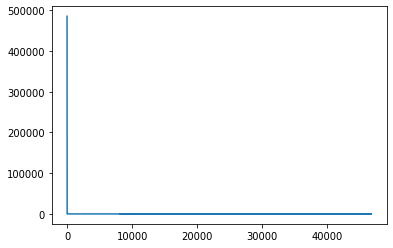

In [21]:
#посмотрим зависимость цены на кол-во покупок 
#Обычно
xs_ = list(set(np.around((train_data['lot_price'].dropna() + 1) / 1000000)))
ys_ = np.array([sum(np.around((train_data['lot_price'].dropna() + 1) / 1000000) == i) for i in xs_])
plt.plot(xs_, ys_)

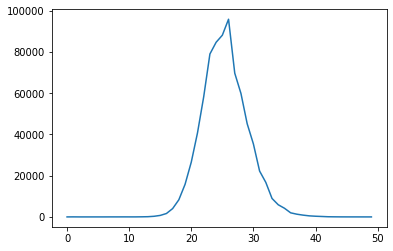

In [22]:
#Логорифмируемая 
xs = list(set(np.around(2 * np.log(features_train['lot_price'].dropna() + 1))))
ys = np.array([sum(np.around(2 * np.log(features_train['lot_price'].dropna() + 1)) == i) for i in xs])
plt.plot(xs, ys) 

In [23]:
# Лографимуем, так как цена более зависима 
features_train['log_price'] = features_train['lot_price'].apply(np.log)
features_test['log_price'] = features_test['lot_price'].apply(np.log)

In [24]:
# максимум, минимум, среднее, медианное значение трейновых фич
okpd2_group_train = features_train
okpd2_group_train = okpd2_group_train.groupby('okpd2_main').apply(lambda x: [list(x['pn_lot_anon']),list(x['fz']), list(x['region_code']),list(x['lot_price'])]).apply(pd.Series)
okpd2_group_train = okpd2_group_train.reset_index()
okpd2_group_train.columns = ['okpd2_main', 'participant_pn_lot_anon', 'list_fz', 'list_region_code','lot_price']
okpd2_group_train = okpd2_group_train.set_index('okpd2_main')
okpd2_groups_train = list(okpd2_group_train.index)
okpd2_price_train = pd.DataFrame(index=okpd2_groups_train,columns=[['maximum','minimum','mean','median','std','var']])
for i in range(0,len(okpd2_groups_train)):
  okpd2_price_train.iloc[i]['maximum'] = max(okpd2_group_train.iloc[i]['lot_price'])
  okpd2_price_train.iloc[i]['minimum'] = min(okpd2_group_train.iloc[i]['lot_price'])
  okpd2_price_train.iloc[i]['mean'] = np.mean(okpd2_group_train.iloc[i]['lot_price'])
  okpd2_price_train.iloc[i]['median'] = np.median(okpd2_group_train.iloc[i]['lot_price'])
  okpd2_price_train.iloc[i]['std'] = np.std(okpd2_group_train.iloc[i]['lot_price'])
  okpd2_price_train.iloc[i]['var'] = np.var(okpd2_group_train.iloc[i]['lot_price'])

In [25]:
# максимум, минимум, среднее, медианное значение тестовых фич
okpd2_group_test = features_test
okpd2_group_test = okpd2_group_test.groupby('okpd2_main').apply(lambda x: [list(x['pn_lot_anon']),list(x['fz']), list(x['region_code']),list(x['lot_price'])]).apply(pd.Series)
okpd2_group_test = okpd2_group_test.reset_index()
okpd2_group_test.columns = ['okpd2_main', 'participant_pn_lot_anon', 'list_fz', 'list_region_code','lot_price']
okpd2_group_test = okpd2_group_test.set_index('okpd2_main')
okpd2_groups_test = list(okpd2_group_test.index)
okpd2_price_test = pd.DataFrame(index=okpd2_groups_test,columns=[['maximum','minimum','mean','median','std','var']])
for i in range(0,len(okpd2_groups_test)):
  okpd2_price_test.iloc[i]['maximum'] = max(okpd2_group_test.iloc[i]['lot_price'])
  okpd2_price_test.iloc[i]['minimum'] = min(okpd2_group_test.iloc[i]['lot_price'])
  okpd2_price_test.iloc[i]['mean'] = np.mean(okpd2_group_test.iloc[i]['lot_price'])
  okpd2_price_test.iloc[i]['median'] = np.median(okpd2_group_test.iloc[i]['lot_price'])
  okpd2_price_test.iloc[i]['std'] = np.std(okpd2_group_test.iloc[i]['lot_price'])
  okpd2_price_test.iloc[i]['var'] = np.var(okpd2_group_test.iloc[i]['lot_price'])

In [26]:
def mergeTwoByCode(first, second):
    result = np.empty([first.shape[0], 6], dtype=float)
    find_index = second.index
    get = [None] * 100
    for i in range(len(second.index)):
        get[int(find_index[i])] = second.iloc[i].array
    for i in range(len(first.index)):
        value = first.iloc[i]['okpd2_main']
        result[i] = get[int(value)]
    df2 = pd.DataFrame(result, columns=['maximum','minimum','mean','median','std','var'])
    return pd.concat([first.reset_index(), df2], axis=1)

In [27]:
features_train = mergeTwoByCode(features_train,okpd2_price_train)

In [28]:
features_test = mergeTwoByCode(features_test,okpd2_price_test)

In [29]:
# Отличие цены лота от максимума цены для любого лота из okpd2 данного лота
features_train['difference_maximum'] = features_train['lot_price']-features_train['maximum']
features_test['difference_maximum']  = features_test['lot_price']-features_test['maximum']

In [30]:
# Отличие цены лота от минимума цены для любого лота из okpd2 данного лота
features_train['difference_minimum'] = features_train['lot_price']-features_train['minimum']
features_test['difference_minimum']  = features_test['lot_price']-features_test['minimum']

In [31]:
# Отличие цены лота от средней цены для любого лота из okpd2 данного лота
features_train['difference_mean'] = features_train['lot_price']-features_train['mean']
features_test['difference_mean']  = features_test['lot_price']-features_test['mean']

In [32]:
# Отличие цены лота от медианной цены для любого лота
features_train['difference_median'] = features_train['lot_price']-features_train['median']
features_test['difference_median']  = features_test['lot_price']-features_test['median']

In [33]:
# Отличие цены лота от std цены для любого лота
features_train['difference_std'] = features_train['lot_price']-features_train['std']
features_test['difference_std']  = features_test['lot_price']-features_test['std']

In [34]:
# Отличие цены лота от var цены для любого лота
features_train['difference_var'] = features_train['lot_price']-features_train['var']
features_test['difference_var']  = features_test['lot_price']-features_test['var']

In [35]:
features_train.head(3)

,index,pn_lot_anon,fz,region_code,lot_price,okpd2_main,okpd2_second,data_delta,log_price,maximum,minimum,mean,median,std,var,difference_maximum,difference_minimum,difference_mean,difference_median,difference_std,difference_var
0,0,pn_lot_7031618,0,2,123500.0,69.0,20.0,529,11.723996,4.236000e+08,1.00,3.406165e+06,338200.0,1.685227e+07,2.839989e+14,-4.234765e+08,123499.00,-3.282665e+06,-214700.0,-1.672877e+07,-2.839989e+14
1,1,pn_lot_7808247,0,2,144000.0,26.0,40.0,696,11.877569,4.334571e+09,546.66,3.071054e+06,315000.0,3.631111e+07,1.318497e+15,-4.334427e+09,143453.34,-2.927054e+06,-171000.0,-3.616711e+07,-1.318497e+15
2,2,pn_lot_7009496,0,2,124200.0,26.0,20.0,694,11.729648,4.334571e+09,546.66,3.071054e+06,315000.0,3.631111e+07,1.318497e+15,-4.334447e+09,123653.34,-2.946854e+06,-190800.0,-3.618691e+07,-1.318497e+15


In [36]:
features_test.head(3)

,index,pn_lot_anon,fz,region_code,lot_price,okpd2_main,okpd2_second,data_delta,log_price,maximum,minimum,mean,median,std,var,difference_maximum,difference_minimum,difference_mean,difference_median,difference_std,difference_var
0,0,pn_lot_2889061,0,2,135000.00,69.0,20.0,102,11.813030,2.460000e+07,38872.66,2.147561e+06,513333.33,3.690514e+06,1.361990e+13,-2.446500e+07,96127.34,-2.012561e+06,-378333.33,-3.555514e+06,-1.361990e+13
1,1,pn_lot_5769273,0,2,1474449.27,31.0,0.0,247,14.203795,9.720704e+07,4640.00,1.496817e+06,422826.70,4.764893e+06,2.270421e+13,-9.573259e+07,1469809.27,-2.236807e+04,1051622.57,-3.290444e+06,-2.270421e+13
2,2,pn_lot_3605798,0,2,1053275.46,58.0,20.0,247,13.867415,6.132701e+08,1343.75,1.958969e+06,179866.66,2.077051e+07,4.314139e+14,-6.122169e+08,1051931.71,-9.056938e+05,873408.80,-1.971723e+07,-4.314139e+14


In [37]:
del features_train['index']
del features_test['index']

<hr>

#### Формирование описания тендера

In [38]:
#все инн
inn_kpps = set(train_labels['participant_inn_kpp_anon'])
#все лоты
pn_lots = set(train_data['pn_lot_anon'])

In [39]:
inn_kpp_history_train = pd.merge(train_labels, features_train[['pn_lot_anon','region_code', 'okpd2_main']], on=['pn_lot_anon'])
inn_kpp_history_train = inn_kpp_history_train.groupby('participant_inn_kpp_anon').apply(lambda x: [list(x['pn_lot_anon']),list(x['is_winner']), list(x['fz']), list(x['region_code']), list(x['okpd2_main'])]).apply(pd.Series)
inn_kpp_history_train = inn_kpp_history_train.reset_index()
inn_kpp_history_train.columns = ['participant_pn_lot_anon', 'list_participant_inn_kpp_anon','list_is_winner', 'list_fz', 'list_region_code','list_okpd2_main']

In [40]:
features_train = features_train.set_index('pn_lot_anon')
features_test = features_test.set_index('pn_lot_anon')

Смотрим на данные, все проверяем


In [41]:
features_train

,fz,region_code,lot_price,okpd2_main,okpd2_second,data_delta,log_price,maximum,minimum,mean,median,std,var,difference_maximum,difference_minimum,difference_mean,difference_median,difference_std,difference_var
pn_lot_anon,,,,,,,,,,,,,,,,,,,
pn_lot_7031618,0,2,123500.0,69.0,20.0,529,11.723996,4.236000e+08,1.00,3.406165e+06,338200.0,1.685227e+07,2.839989e+14,-4.234765e+08,123499.00,-3.282665e+06,-214700.0,-1.672877e+07,-2.839989e+14
pn_lot_7808247,0,2,144000.0,26.0,40.0,696,11.877569,4.334571e+09,546.66,3.071054e+06,315000.0,3.631111e+07,1.318497e+15,-4.334427e+09,143453.34,-2.927054e+06,-171000.0,-3.616711e+07,-1.318497e+15
pn_lot_7009496,0,2,124200.0,26.0,20.0,694,11.729648,4.334571e+09,546.66,3.071054e+06,315000.0,3.631111e+07,1.318497e+15,-4.334447e+09,123653.34,-2.946854e+06,-190800.0,-3.618691e+07,-1.318497e+15
pn_lot_5938735,0,2,50000.0,46.0,50.0,694,10.819778,3.728994e+10,0.01,1.073102e+07,631957.5,3.665663e+08,1.343708e+17,-3.728989e+10,49999.99,-1.068102e+07,-581957.5,-3.665163e+08,-1.343708e+17
pn_lot_9327348,0,2,493441.0,26.0,20.0,590,13.109159,4.334571e+09,546.66,3.071054e+06,315000.0,3.631111e+07,1.318497e+15,-4.334078e+09,492894.34,-2.577613e+06,178441.0,-3.581767e+07,-1.318497e+15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
pn_lot_2387328,0,44,100.0,6.0,10.0,708,4.605170,2.256641e+08,1.00,5.562163e+06,364000.0,3.037365e+07,9.225585e+14,-2.256640e+08,99.00,-5.562063e+06,-363900.0,-3.037355e+07,-9.225585e+14
pn_lot_2416734,0,44,100.0,6.0,10.0,703,4.605170,2.256641e+08,1.00,5.562163e+06,364000.0,3.037365e+07,9.225585e+14,-2.256640e+08,99.00,-5.562063e+06,-363900.0,-3.037355e+07,-9.225585e+14
pn_lot_1607958,0,44,100.0,6.0,10.0,689,4.605170,2.256641e+08,1.00,5.562163e+06,364000.0,3.037365e+07,9.225585e+14,-2.256640e+08,99.00,-5.562063e+06,-363900.0,-3.037355e+07,-9.225585e+14


# Классификация и тренировка для каждой организации отдельно

In [42]:
# Скачиваем библиотеки 
!pip install catboost
import sklearn
from sklearn.model_selection import train_test_split
import time
import random
from catboost import CatBoostClassifier, Pool

In [43]:
features_train

,fz,region_code,lot_price,okpd2_main,okpd2_second,data_delta,log_price,maximum,minimum,mean,median,std,var,difference_maximum,difference_minimum,difference_mean,difference_median,difference_std,difference_var
pn_lot_anon,,,,,,,,,,,,,,,,,,,
pn_lot_7031618,0,2,123500.0,69.0,20.0,529,11.723996,4.236000e+08,1.00,3.406165e+06,338200.0,1.685227e+07,2.839989e+14,-4.234765e+08,123499.00,-3.282665e+06,-214700.0,-1.672877e+07,-2.839989e+14
pn_lot_7808247,0,2,144000.0,26.0,40.0,696,11.877569,4.334571e+09,546.66,3.071054e+06,315000.0,3.631111e+07,1.318497e+15,-4.334427e+09,143453.34,-2.927054e+06,-171000.0,-3.616711e+07,-1.318497e+15
pn_lot_7009496,0,2,124200.0,26.0,20.0,694,11.729648,4.334571e+09,546.66,3.071054e+06,315000.0,3.631111e+07,1.318497e+15,-4.334447e+09,123653.34,-2.946854e+06,-190800.0,-3.618691e+07,-1.318497e+15
pn_lot_5938735,0,2,50000.0,46.0,50.0,694,10.819778,3.728994e+10,0.01,1.073102e+07,631957.5,3.665663e+08,1.343708e+17,-3.728989e+10,49999.99,-1.068102e+07,-581957.5,-3.665163e+08,-1.343708e+17
pn_lot_9327348,0,2,493441.0,26.0,20.0,590,13.109159,4.334571e+09,546.66,3.071054e+06,315000.0,3.631111e+07,1.318497e+15,-4.334078e+09,492894.34,-2.577613e+06,178441.0,-3.581767e+07,-1.318497e+15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
pn_lot_2387328,0,44,100.0,6.0,10.0,708,4.605170,2.256641e+08,1.00,5.562163e+06,364000.0,3.037365e+07,9.225585e+14,-2.256640e+08,99.00,-5.562063e+06,-363900.0,-3.037355e+07,-9.225585e+14
pn_lot_2416734,0,44,100.0,6.0,10.0,703,4.605170,2.256641e+08,1.00,5.562163e+06,364000.0,3.037365e+07,9.225585e+14,-2.256640e+08,99.00,-5.562063e+06,-363900.0,-3.037355e+07,-9.225585e+14
pn_lot_1607958,0,44,100.0,6.0,10.0,689,4.605170,2.256641e+08,1.00,5.562163e+06,364000.0,3.037365e+07,9.225585e+14,-2.256640e+08,99.00,-5.562063e+06,-363900.0,-3.037355e+07,-9.225585e+14


In [44]:
inn_kpp_history_train

,participant_pn_lot_anon,list_participant_inn_kpp_anon,list_is_winner,list_fz,list_region_code,list_okpd2_main
0,inn_kpp_1000018,"[pn_lot_5330449, pn_lot_648665, pn_lot_81155, ...","[0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, ...","[44fz, 44fz, 44fz, 44fz, 44fz, 44fz, 44fz, 44f...","[64, 50, 50, 77, 50, 64, 77, 77, 77, 77, 50, 7...","[58.0, 26.0, 26.0, 26.0, 26.0, 58.0, 26.0, 27...."
1,inn_kpp_1001268,"[pn_lot_7608031, pn_lot_9976372, pn_lot_671651...","[1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, ...","[44fz, 44fz, 44fz, 44fz, 44fz, 44fz, 44fz, 44f...","[77, 79, 79, 79, 79, 27, 79, 79, 79, 79, 79, 7...","[86.0, 86.0, 86.0, 86.0, 86.0, 86.0, 86.0, 86...."
2,inn_kpp_1002518,"[pn_lot_5287076, pn_lot_7474816, pn_lot_121000...","[0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, ...","[44fz, 44fz, 44fz, 44fz, 44fz, 44fz, 44fz, 44f...","[41, 27, 82, 65, 65, 65, 41, 41, 41, 41, 82, 4...","[30.0, 27.0, 27.0, 25.0, 30.0, 29.0, 25.0, 25...."
3,inn_kpp_1003261,[pn_lot_2647783],[1],[223fz],[54],[28.0]
4,inn_kpp_1003291,"[pn_lot_7794721, pn_lot_4767800, pn_lot_915979...","[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, ...","[44fz, 44fz, 44fz, 44fz, 44fz, 44fz, 44fz, 44f...","[50, 12, 50, 50, 51, 69, 11, 12, 11, 12, 12, 1...","[32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 21...."
...,...,...,...,...,...,...
16485,inn_kpp_9996627,"[pn_lot_7946989, pn_lot_945176, pn_lot_3503646...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[44fz, 44fz, 44fz, 223fz, 44fz, 44fz, 44fz, 44...","[66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 6...","[43.0, 43.0, 43.0, 43.0, 43.0, 42.0, 42.0, 43...."
16486,inn_kpp_9997846,"[pn_lot_4141328, pn_lot_6838981, pn_lot_4668669]","[1, 0, 0]","[44fz, 44fz, 44fz]","[5, 5, 5]","[42.0, 42.0, 42.0]"
16487,inn_kpp_9997944,"[pn_lot_274406, pn_lot_1371030, pn_lot_2180007...","[1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, ...","[44fz, 44fz, 44fz, 44fz, 44fz, 44fz, 44fz, 44f...","[25, 25, 25, 25, 25, 25, 25, 25, 25, 65, 27, 2...","[41.0, 43.0, 43.0, 43.0, 43.0, 43.0, 42.0, 42...."
16488,inn_kpp_9998925,"[pn_lot_9101115, pn_lot_3771565, pn_lot_900669...","[0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, ...","[44fz, 44fz, 44fz, 44fz, 223fz, 44fz, 44fz, 44...","[63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 6...","[43.0, 43.0, 42.0, 43.0, 8.0, 43.0, 42.0, 42.0..."


# Новый раздел

In [45]:
answer = []
errors = []

In [ ]:
start = time.time()
for i in range(froms,tos+1): #поставить свои значения
  print(i)
  stroka = inn_kpp_history_train.iloc[i]
  region_code_list = list(set(stroka[4]))
  okpd2_list = list(set(stroka[5]))

  data_of_inn = pd.DataFrame(index=pn_lots,columns=[stroka[0]])
  for j in stroka[1]:
    data_of_inn.loc[j,stroka[0]]=1
    
  data_of_inn = data_of_inn.fillna(0)
  data_of_inn = data_of_inn.reset_index()
  data_of_inn = data_of_inn.rename({'index':'pn_lot_anon'}, axis=1) # data_of_inn  - y     features_train - x
  DATA_ALL = pd.merge(features_train, data_of_inn, on=['pn_lot_anon'])
  DATA_ALL = DATA_ALL.set_index('pn_lot_anon')


  DATA_TMP = DATA_ALL
  DATA_TMP = DATA_TMP[[i in okpd2_list for i in DATA_TMP['okpd2_main']]]
  DATA_TMP = DATA_TMP[[i in region_code_list for i in DATA_TMP['region_code']] ]
  if(len(DATA_TMP.index.tolist())<70):
      DATA_TMP = DATA_ALL
      DATA_TMP = DATA_TMP[[i in okpd2_list for i in DATA_TMP['okpd2_main']]]
  if(len(DATA_TMP.index.tolist())<70):
      DATA_TMP = DATA_ALL
      DATA_TMP = DATA_TMP[[i in region_code_list for i in DATA_TMP['region_code']] ]
  if(len(DATA_TMP.index.tolist())<70 or (len(region_code_list)==1 or len(okpd2_list)==1)):
      DATA_TMP = DATA_ALL
  DATA_ALL = DATA_TMP



  trainings_data, testings_data = sklearn.model_selection.train_test_split(DATA_ALL)
  #трейнинг чтоб обучалось
  y_training=trainings_data[stroka[0]]
  X_training=trainings_data[['fz','region_code','lot_price','okpd2_main','log_price','okpd2_second','data_delta','maximum','minimum','mean','median','std','var','difference_maximum','difference_minimum','difference_mean','difference_median','difference_std','difference_var']]
  #тестинг чтоб тестилось
  y_testing=testings_data[stroka[0]]
  X_testing=testings_data[['fz','region_code','lot_price','okpd2_main','log_price','okpd2_second','data_delta','maximum','minimum','mean','median','std','var','difference_maximum','difference_minimum','difference_mean','difference_median','difference_std','difference_var']]
  #тест для решения
  X_test=features_test
  X_test = X_test[[i in okpd2_list for i in X_test['okpd2_main']]]
  X_test = X_test[[i in region_code_list for i in X_test['region_code']]]
  if(len(X_test.index.tolist())<35):
      X_test=features_test
      X_test = X_test[[i in okpd2_list for i in X_test['okpd2_main']]]
  if(len(X_test.index.tolist())<35):
      X_test=features_test
      X_test = X_test[[i in okpd2_list for i in X_test['region_code']]]
  if(len(X_test.index.tolist())<35 or (len(region_code_list)==1 or len(okpd2_list)==1)):
      X_test=features_test
  #тренировка ИИ



  try:
    train_pool = Pool(data=X_training, label=y_training)
    eval_pool = Pool(data=X_testing,label=y_testing)
    rnd = random.randint(1, 10000000)
    catboost_params = {
        'learning_rate' : 0.1,
        'max_depth' : 3,
        'iterations': 500,
        'task_type' : "GPU",
        'eval_metric': 'Recall',
        'verbose' : 0,
        'random_seed': rnd
    }
    model = CatBoostClassifier(**catboost_params)
    model = model.fit(train_pool,eval_set=eval_pool)
  except:
    try:
        train_pool = Pool(data=DATA_ALL[['fz','region_code','lot_price','okpd2_main','log_price','maximum','minimum','mean','median','difference_maximum','difference_minimum','difference_mean','difference_median']], label=DATA_ALL[stroka[0]])
        rnd = random.randint(1, 10000000)
        catboost_params = {
            'learning_rate' : 0.1,
            'max_depth' : 3,
            'iterations': 500,
            'eval_metric': 'Recall',
            'task_type' : "GPU",
            'verbose' : 0,
            'random_seed': rnd
        }
        model = CatBoostClassifier(**catboost_params)
        model = model.fit(train_pool)
    except:
        errors.append(inn_kpp_history_train['participant_pn_lot_anon'][i])
        continue

  ##### резы теста
  name_of_lots = X_test.index.tolist()
  pred=model.predict_proba(X_test)

  k = 0
  pairs = []
  for j in pred:
    pair = [j[1],k]
    pairs.append(pair)
    k+=1
  pairs.sort(key=lambda x: x[0])
  print(inn_kpp_history_train['participant_pn_lot_anon'][i],i)
  for j in range(1,35+1):
    answer.append({
        'inn_kpp': inn_kpp_history_train['participant_pn_lot_anon'][i],
        'actual_recommended_pn_lot': name_of_lots[pairs[-j][1]],
        'similarity_score': pairs[-j][0]
    })
print(time.time()-start) #подсчет времени

6000
inn_kpp_4292189 6000
6001
inn_kpp_4293016 6001
6002
inn_kpp_4293386 6002
6003
inn_kpp_4293669 6003
6004
inn_kpp_4294544 6004
6005
inn_kpp_429474 6005
6006
inn_kpp_429515 6006
6007
inn_kpp_429532 6007
6008
inn_kpp_4295856 6008
6009
inn_kpp_4296223 6009
6010
inn_kpp_4296479 6010
6011
inn_kpp_4297299 6011
6012
inn_kpp_4298542 6012
6013
inn_kpp_4299084 6013
6014
inn_kpp_4299559 6014
6015
inn_kpp_4301975 6015
6016
inn_kpp_4302180 6016
6017
inn_kpp_4302194 6017
6018
inn_kpp_4302405 6018
6019
inn_kpp_4302830 6019
6020
inn_kpp_4302961 6020
6021
inn_kpp_430541 6021
6022
inn_kpp_4306099 6022
6023
inn_kpp_4306680 6023
6024
inn_kpp_4307607 6024
6025
inn_kpp_4307867 6025
6026
inn_kpp_4308195 6026
6027
inn_kpp_4308211 6027
6028
inn_kpp_4308263 6028
6029
inn_kpp_4308422 6029
6030
inn_kpp_4308662 6030
6031
inn_kpp_4309559 6031
6032
inn_kpp_4309774 6032
6033
inn_kpp_4309829 6033
6034
inn_kpp_4310 6034
6035
inn_kpp_4310075 6035
6036
inn_kpp_4310254 6036
6037
inn_kpp_4310260 6037
6038
inn_kpp_431070

In [ ]:
import csv
with open('org.csv', 'w', newline="") as file:
    writer = csv.writer(file, delimiter=';')
    writer.writerow(['inn_kpp,actual_recommended_pn_lot,similarity_score'])
    for one_answer in answer:
      writer.writerow([one_answer['inn_kpp'],one_answer['actual_recommended_pn_lot'],one_answer['similarity_score']])

# Новый раздел

# **КОНЕЦ**

# Новый раздел

# Новый раздел

# Новый раздел

# Новый раздел

# Новый раздел

# Новый раздел

# Новый раздел

# Новый раздел

# Новый раздел

# Новый раздел

# Новый раздел

# Новый раздел

# Новый раздел

# Новый раздел

# Новый раздел

# Новый раздел

# Новый раздел

# Новый раздел

# Новый раздел

# Новый раздел

# Новый раздел

# Новый раздел

# Новый раздел

# Новый раздел

# Новый раздел

# Новый раздел

# Новый раздел

# Новый раздел

# Новый раздел

# Новый раздел